In [216]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sparseqr

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

# For mean_l = 2 * side_length / N**0.5, a -> a * 8 / 10 approx

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2 
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

In [207]:
class RGG(Graph, Flat):

    def __init__(self, N):

        self.construct_V_coords(N)
        self.construct_data()
        print(f"num_Vs = {self.num_Vs}")
        self.construct_NEP_data()
        self.plot_graph()

    def construct_NEP_data(self):

        interior_V_num = np.arange(self.num_bulk_Vs)
        wadjacency_matrix = scipy.sparse.lil_matrix((self.num_bulk_Vs, self.num_bulk_Vs))

        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            wrapped_v_ind = self.bulk_and_boundary_to_bulk_map[v_ind]
            wrapped_w_ind = self.bulk_and_boundary_to_bulk_map[w_ind]
            wadjacency_matrix[wrapped_v_ind, wrapped_w_ind] = l_vw
            wadjacency_matrix[wrapped_w_ind, wrapped_v_ind] = l_vw

        # Define class attributes
        self.interior_V_num = interior_V_num
        self.wadjacency_matrix = wadjacency_matrix.tocsc()

    def construct_V_coords(self, N):

        min_coord = -0.2
        max_coord = 1.2

        full_V_coords = np.random.uniform(min_coord, max_coord, size=(N, 2))
        bulk_mask = ((0 < full_V_coords[:, 0]) & (0 < full_V_coords[:, 1]) 
                     & (full_V_coords[:, 0] < 1) & (full_V_coords[:, 1] < 1))
        num_bulk_Vs = np.sum(bulk_mask)
        full_V_coords = np.vstack((full_V_coords[bulk_mask], full_V_coords[~bulk_mask]))

        tree = scipy.spatial.cKDTree(full_V_coords)
        mean_l = 2 * np.abs(max_coord - min_coord) / np.sqrt(N)
        neighbors = np.array(list(tree.query_pairs(r=mean_l)))
        neighbors = np.sort(neighbors, axis=1)

        bulk_edges = []
        boundary_edges = []
        boundary_V_inds = []
        for v_ind, w_ind in neighbors:
            if v_ind < num_bulk_Vs:
                if w_ind < num_bulk_Vs:
                    bulk_edges.append([v_ind, w_ind])
                else:
                    if not np.any(full_V_coords[w_ind] < 0):
                        boundary_edges.append([v_ind, w_ind])
                        boundary_V_inds.append(w_ind)
        bulk_edges = np.array(bulk_edges)
        boundary_edges = np.array(boundary_edges)
        boundary_V_inds = np.unique(boundary_V_inds)

        # Reindex full_V_coords to construct subset: V_coords (just bulk and boundary vertices)
        old_bulk_and_boundary_V_inds = np.concatenate((np.arange(num_bulk_Vs), boundary_V_inds))
        V_coords = full_V_coords[old_bulk_and_boundary_V_inds]

        # Fix indices in bulk and boundary edges. Create full edges
        num_boundary_Vs = boundary_V_inds.shape[0]
        new_bulk_and_boundary_V_inds = np.arange(num_bulk_Vs + num_boundary_Vs)
        old_to_new = {i: j for i, j in zip(old_bulk_and_boundary_V_inds, new_bulk_and_boundary_V_inds)}
        edges = []
        for v_ind, w_ind in np.vstack((bulk_edges, boundary_edges)):
            edges.append([old_to_new[v_ind], old_to_new[w_ind]])
        edges = np.array(edges)

        # Define class attributes
        self.full_V_coords = full_V_coords
        self.num_bulk_Vs = num_bulk_Vs
        self.num_boundary_Vs = num_boundary_Vs
        self.V_coords = V_coords
        self.num_Vs = self.V_coords.shape[0]
        self.edges = edges
        self.mean_l = mean_l
        self.neighbors = neighbors

    def construct_data(self):

        # Construct boundary map
        bulk_and_boundary_to_bulk_map = {bulk_v_num: bulk_v_num for bulk_v_num in range(self.num_bulk_Vs)}
        for boundary_v_ind in range(self.num_bulk_Vs, self.num_Vs):
            wrapped_w_coord = self.V_coords[boundary_v_ind] % 1
            distances = np.linalg.norm(self.V_coords[:self.num_bulk_Vs] - wrapped_w_coord, axis=1)
            wrapped_v_ind = distances.argmin()
            bulk_and_boundary_to_bulk_map[boundary_v_ind] = wrapped_v_ind

        LHS = scipy.sparse.lil_matrix((self.num_bulk_Vs + 1, self.num_bulk_Vs))
        RHS = np.zeros((self.num_bulk_Vs + 1, 2))
        for v_ind, w_ind in self.edges:
            l_vw = self.calculate_l_vw(v_ind, w_ind)
            wrapped_v_ind = bulk_and_boundary_to_bulk_map[v_ind]
            wrapped_w_ind = bulk_and_boundary_to_bulk_map[w_ind]
            LHS[wrapped_v_ind, wrapped_w_ind] -= 1 / l_vw
            LHS[wrapped_w_ind, wrapped_v_ind] -= 1 / l_vw
            LHS[wrapped_v_ind, wrapped_v_ind] += 1 / l_vw
            LHS[wrapped_w_ind, wrapped_w_ind] += 1 / l_vw

            r_xy = self.calculate_r_xy(v_ind, w_ind)
            RHS[wrapped_v_ind] += r_xy / l_vw
            RHS[wrapped_w_ind] -= r_xy / l_vw

        LHS[-1] = np.ones(self.num_bulk_Vs)
        LHS = scipy.sparse.csc_matrix(LHS)

        self.LHS = LHS
        self.RHS = RHS
        self.bulk_and_boundary_to_bulk_map = bulk_and_boundary_to_bulk_map

    def plot_graph(self):

        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111)
        
        # Plot the points
        ax.scatter(self.full_V_coords[:, 0], self.full_V_coords[:, 1], color='blue', s=3)
        
        # Plot the lines between neighbors
        for i, j in self.neighbors:
            point1 = self.full_V_coords[i]
            point2 = self.full_V_coords[j]
            ax.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', linewidth=0.1)

        # for en, v in enumerate(self.full_V_coords):
        #     ax.annotate(str(en), v, fontsize=20)

        for i in [0]:
            for j in [0]:
                if i == 0 and j == 0: lw = 3
                else: lw = 1
                ax.add_patch(matplotlib.patches.Rectangle((i, j), 1, 1, linewidth=lw, edgecolor='orange', facecolor='none'))
    
        ax.set_xlim(-0.15, 1.15)
        ax.set_ylim(-0.15, 1.15)
        plt.show()

    def calculate_l_vw(self, v_ind, w_ind):
        return np.linalg.norm(self.V_coords[v_ind] - self.V_coords[w_ind])
    
    def calculate_r_xy(self, v_ind, w_ind):
        v_coords = self.V_coords[v_ind]
        w_coords = self.V_coords[w_ind]
        
        v_x_coords = self.v_coords_to_x_coords(v_coords)
        w_x_coords = self.v_coords_to_x_coords(w_coords)

        r_xy = w_x_coords - v_x_coords

        return r_xy

    def v_coords_to_x_coords(self, v_coords):
        x_coords = []
        for d in range(v_coords.shape[0]):
            if v_coords[d] < 0:
                x_coords.append(-0.5)
            elif v_coords[d] < 1:
                x_coords.append(0.5)
            else:
                x_coords.append(1.5)
        x_coords = np.array(x_coords)

        return x_coords

num_Vs = 5187


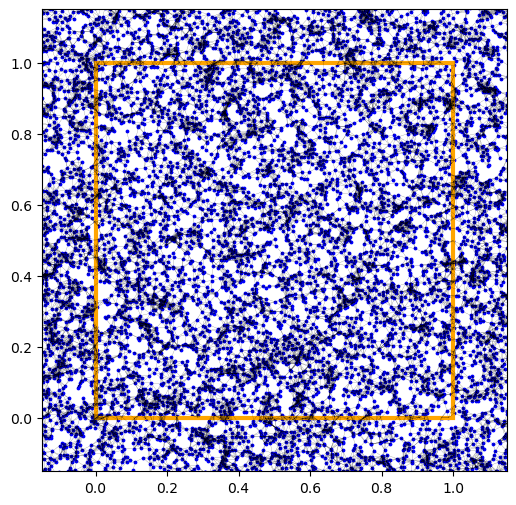

In [212]:
np.random.seed(0)
g = RGG(10000)

In [213]:
eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)

In [214]:
guesses = np.linspace(3.5, 4.3, 30)
print(guesses)

solutions = eigs(guesses, solve_type="SVD iterate", printerval=1, max_steps=20)

[3.5        3.52758621 3.55517241 3.58275862 3.61034483 3.63793103
 3.66551724 3.69310345 3.72068966 3.74827586 3.77586207 3.80344828
 3.83103448 3.85862069 3.8862069  3.9137931  3.94137931 3.96896552
 3.99655172 4.02413793 4.05172414 4.07931034 4.10689655 4.13448276
 4.16206897 4.18965517 4.21724138 4.24482759 4.27241379 4.3       ]

Calculating eig number 0

Count = 1
k = 3.5

Count = 2
k = 3.521645113726455

Count = 3
k = 3.521711439404263

Count = 4
k = 3.5217114372067857

Count = 5
k = 3.52171143720687

Count = 6
k = 3.521711437206884

----------------------
Converged at step 5:

k = 3.521711437206876
----------------------

Calculating eig number 1

Count = 1
k = 3.527586206896552

Count = 2
k = 3.5334657932818123

Count = 3
k = 3.521692057487065

Count = 4
k = 3.5217114369395457

Count = 5
k = 3.521711437206873

----------------------
Converged at step 4:

k = 3.5217114372068727
----------------------

Calculating eig number 2

Count = 1
k = 3.5551724137931036

Count = 2
k = 3.5

In [217]:
print(solutions)
print()
print(np.unique(np.round(solutions, 10))[:4])
mean_eig = np.mean(np.unique(np.round(solutions, 10))[:4])
print(mean_eig)

[3.52171144 3.52171144 3.52171144 3.52171144 3.69109888 3.69109888
 3.69109888 3.69109888 3.71408453 3.76632448 3.76632448 3.76632448
 3.76632448 3.76632448 3.76632448 3.76632448 3.76632448 3.76632448
 3.76632448 3.76632448 3.76632448 3.76632448 3.76632448 3.76632448
 3.76632448 3.76632448 3.76632448 3.76632448 3.76632448 3.76632448]

[3.52171144 3.69109888 3.71408453 3.76632448]
3.673304830925


In [223]:
calculate_pde_eigenvalues(1, 0) * np.sqrt(0.6958141938918613)

3.70605203157634

In [ ]:
# 2700 Vs  : mean = 3.915559335550
# 10505 Vs : mean = 3.915985768275, c = 0.7989012791799868

In [219]:
alpha_x = sparseqr.solve(g.LHS, g.RHS[:, 0]) #, tolerance = 1e-9)
alpha_y = sparseqr.solve(g.LHS, g.RHS[:, 1]) #, tolerance = 1e-9)
alpha = np.vstack((alpha_x, alpha_y)).T
print(f"err = {np.linalg.norm(g.LHS @ alpha - g.RHS)}")

err = 7.70923319852694e-11


In [220]:
Q = np.zeros((2, 2))
T = 0

for v_ind, w_ind in g.edges:
        
    l_vw = g.calculate_l_vw(v_ind, w_ind)
    r_xy = g.calculate_r_xy(v_ind, w_ind)

    a_vw = r_xy + alpha[g.bulk_and_boundary_to_bulk_map[w_ind]] - alpha[g.bulk_and_boundary_to_bulk_map[v_ind]]

    q = np.tensordot(a_vw, a_vw, axes=0) / l_vw

    Q += q
    T += l_vw

print(Q / T)
print()
print(np.trace(Q / T))

[[ 0.35323454 -0.0062156 ]
 [-0.0062156   0.34257965]]

0.6958141938918613
